In [81]:
# Lab Logistic Regression - Sakila Movie Rental Database

#In order to optimize our inventory, we would like to know which films will be 
#rented next month and we are asked to create a model to predict it.

In [188]:
#1 Create the MySQL connection

import pymysql
from sqlalchemy import create_engine
import pandas as pd
import numpy as np
import getpass  # To get the password without showing the input
password = getpass.getpass()

connection_string = 'mysql+pymysql://root:' + password + '@localhost/bank'
engine = create_engine(connection_string)

 ··········


In [202]:
#2 Define data query - using a view created in MySQL 
# (it's annoying that queries created in Workbench do not work out of the box in Python...)

query = '''
SELECT * FROM sakila.sakila_logistic
'''
data = pd.read_sql_query(query, engine)
data.head()

,title,release_year,lang,rental_rate,length,rating,special_features,times_rented_before_aug,rented_in_aug,genre
0,ACADEMY DINOSAUR,2006,English,0.99,86,PG,"Deleted Scenes,Behind the Scenes",14.0,Yes,Documentary
1,ACE GOLDFINGER,2006,English,4.99,48,G,"Trailers,Deleted Scenes",2.0,Yes,Horror
2,ADAPTATION HOLES,2006,English,2.99,50,NC-17,"Trailers,Deleted Scenes",6.0,Yes,Documentary
3,AFFAIR PREJUDICE,2006,English,2.99,117,G,"Commentaries,Behind the Scenes",16.0,Yes,Horror
4,AFRICAN EGG,2006,English,2.99,130,G,Deleted Scenes,8.0,Yes,Family


In [190]:
#3 Reviewing data

data.shape # 1000 rows, 10 columns
data.dtypes # all types look correct, 4 numerical, 6 categorical (5 excl. film title)
data.isna().sum() # 42 NaNs in times_rented_before_aug and rented_in_aug
data['title'].value_counts() # obviously 1000 distinct names, will be dropped for the sake of the model but included back in testing
data['release_year'].value_counts() # all movies are released in 2006, can be dropped
data['lang'].value_counts() # all movies are in English, can be dropped
data['rental_rate'].value_counts() # just three rates, keep in the model
data['length'].value_counts() # variaes, keep in model
data['rating'].value_counts() # 5 values, can stay in the model for now
data['special_features'].value_counts() # quite evently distributed but may not be included in the first model run
data['times_rented_before_aug'].value_counts() # multiple values, keep for now
data['rented_in_aug'].value_counts() # 958 'Yes', need to fill the remaining 42 with 'No'
data['genre'].value_counts()

Sports         74
Foreign        73
Family         69
Documentary    68
Animation      66
Action         64
New            63
Drama          62
Sci-Fi         61
Games          61
Children       60
Comedy         58
Travel         57
Classics       57
Horror         56
Music          51
Name: genre, dtype: int64

In [203]:
#4 Wrangling data

# Replacing NaNs
data['times_rented_before_aug'] = data['times_rented_before_aug'].replace(np.nan, 0)
data['rented_in_aug'] = data['rented_in_aug'].replace(np.nan, 'No')

# Saving the dropped columns to a backup df
dropped = data[['title','release_year','lang','special_features']]

# Dropping these columns from main dataframe
data = data.drop(['title','release_year','lang','special_features'], axis = 1)

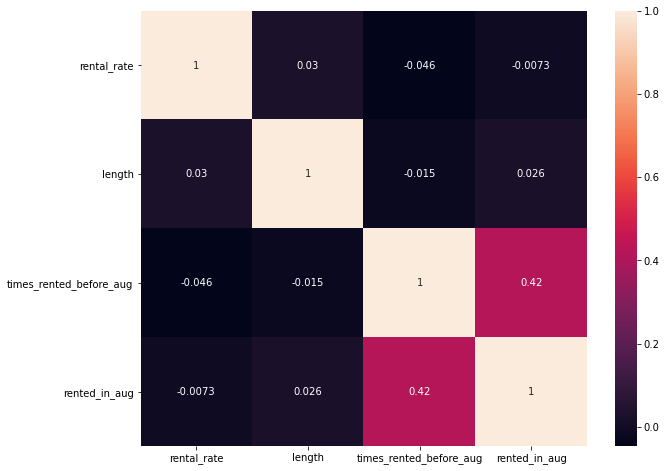

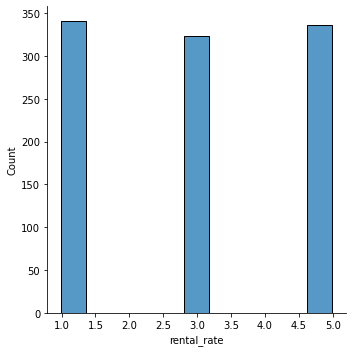

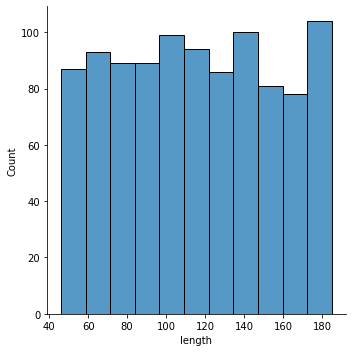

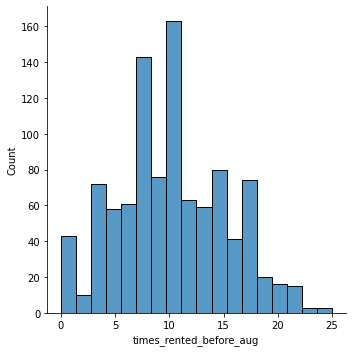

In [138]:
#5 Checking multicolinearity and distributions of numericals

import seaborn as sns
import matplotlib.pyplot as plt

corr_matrix=data.corr()
fig, ax = plt.subplots(figsize=(10, 8))
ax = sns.heatmap(corr_matrix, annot=True)
plt.show() # Numericals not correlated, sweet

sns.displot(data['rental_rate'])
plt.show()
sns.displot(data['length'])
plt.show()
sns.displot(data['times_rented_before_aug'])
plt.show() # different thresholds, need to standardize

In [87]:
#7 Defining y and X

y = data['rented_in_aug']
X = data.drop('rented_in_aug', axis = 1)

In [88]:
#8 Splitting the train and test data before transformations

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=31337)

In [89]:
#9 Standardizing the numericals using MinMaxScaler

from sklearn.preprocessing import MinMaxScaler

X_train_num = X_train.select_dtypes(include = np.number)

transformer = MinMaxScaler().fit(X_train_num)
X_normalized = transformer.transform(X_train_num)
X_train_norm = pd.DataFrame(X_normalized, columns = X_train_num.columns)

In [90]:
#10 Encoding categoricals

X_train_categorical = X_train.select_dtypes(include = object)
X_train_cat = pd.get_dummies(X_train_categorical,
                            columns = ['rating', 'genre'],
                            drop_first = True)

In [91]:
#11 Building final X and y for model training

y_train
X_train_transformed = np.concatenate((X_train_norm, X_train_cat), axis=1)

In [92]:
#12a Creating a logistic regression model (lbfgs)

from sklearn.linear_model import LogisticRegression

model_a = LogisticRegression(random_state=0, solver='lbfgs',
                  multi_class='multinomial').fit(X_train_transformed, y_train)

In [93]:
#12b Creating a logistic regression model (saga), will see which is better later

model_b = LogisticRegression(random_state=0, solver='saga',
                  multi_class='multinomial').fit(X_train_transformed, y_train)

In [94]:
#13 Scaling and encoding test data to run the predictions

X_test_num = X_test.select_dtypes(include = np.number)

X_normalized = transformer.transform(X_test_num)
X_test_norm = pd.DataFrame(X_normalized, columns = X_test_num.columns)

X_test_categorical = X_test.select_dtypes(include = object)
X_test_cat = pd.get_dummies(X_test_categorical,
                            columns = ['rating', 'genre'],
                            drop_first = True)

In [95]:
#14 Checking if test data columns are the same as train data

display(list(zip(list(X_train_cat.columns),list(X_test_cat.columns)))) 

[('rating_NC-17', 'rating_NC-17'),
 ('rating_PG', 'rating_PG'),
 ('rating_PG-13', 'rating_PG-13'),
 ('rating_R', 'rating_R'),
 ('genre_Animation', 'genre_Animation'),
 ('genre_Children', 'genre_Children'),
 ('genre_Classics', 'genre_Classics'),
 ('genre_Comedy', 'genre_Comedy'),
 ('genre_Documentary', 'genre_Documentary'),
 ('genre_Drama', 'genre_Drama'),
 ('genre_Family', 'genre_Family'),
 ('genre_Foreign', 'genre_Foreign'),
 ('genre_Games', 'genre_Games'),
 ('genre_Horror', 'genre_Horror'),
 ('genre_Music', 'genre_Music'),
 ('genre_New', 'genre_New'),
 ('genre_Sci-Fi', 'genre_Sci-Fi'),
 ('genre_Sports', 'genre_Sports'),
 ('genre_Travel', 'genre_Travel')]

In [96]:
#15 Building final X for model training

X_test_transformed = np.concatenate((X_test_norm, X_test_cat), axis=1)

In [97]:
#16 Making predictions using the models and test data

pred_model_a = model_a.predict(X_test_transformed)
display(model_a.score(X_test_transformed, y_test))

pred_model_b = model_b.predict(X_test_transformed)
display(model_b.score(X_test_transformed, y_test))

# Both models return a score of 0.97

0.97

0.97

In [98]:
#17 Checking confusion matrix

# predicted | No | Yes |
# ----------------------
# actual  No | + |     |  
# ----------------------
#        Yes |   |  +  |   

from sklearn.metrics import confusion_matrix

display(confusion_matrix(y_test, pred_model_a))
display(confusion_matrix(y_test, pred_model_b))

# same stats for both models - all of the Yes's guessed correctly (no wonder...) but 6
# values that should be a 'No' were actually guessed as 'Yes'

array([[  0,   6],
       [  0, 194]])

array([[  0,   6],
       [  0, 194]])

In [127]:
#18 Trying the 'Neighbors' model

from sklearn import neighbors

model_c = neighbors.KNeighborsClassifier(n_neighbors=2, weights='uniform', algorithm='brute')
model_c.fit(X_train_transformed, y_train)
pred_model_c = model_c.predict(X_test_transformed) # score is also 0.97

display(confusion_matrix(y_test, pred_model_c)) # getting same results as above...

array([[  0,   6],
       [ 15, 179]])

In [100]:
#19 Conclusions

#The model predicts that essentially all plugged movies will be rented out, 
# while in reality 6 o them were not.
#This is due to the fact that there is a huge imbalance in the data 
#(96% of all movies available were rented in August)

#There is no noticeable differnce between three models tested (lbfgs, saga, neighbors)

In [285]:
#20 [5/11 Update] Ok, let's apply these imbalanced data methods we learnt today

query = '''
SELECT * FROM sakila.sakila_logistic
'''
data = pd.read_sql_query(query, engine)
data.head()

,title,release_year,lang,rental_rate,length,rating,special_features,times_rented_before_aug,rented_in_aug,genre
0,ACADEMY DINOSAUR,2006,English,0.99,86,PG,"Deleted Scenes,Behind the Scenes",14.0,Yes,Documentary
1,ACE GOLDFINGER,2006,English,4.99,48,G,"Trailers,Deleted Scenes",2.0,Yes,Horror
2,ADAPTATION HOLES,2006,English,2.99,50,NC-17,"Trailers,Deleted Scenes",6.0,Yes,Documentary
3,AFFAIR PREJUDICE,2006,English,2.99,117,G,"Commentaries,Behind the Scenes",16.0,Yes,Horror
4,AFRICAN EGG,2006,English,2.99,130,G,Deleted Scenes,8.0,Yes,Family


In [286]:
# Wrangling

# Replacing NaNs
data['times_rented_before_aug'] = data['times_rented_before_aug'].replace(np.nan, 0)
data['rented_in_aug'] = data['rented_in_aug'].replace(np.nan, 'No')

# Saving the dropped columns to a backup df
dropped = data[['title','release_year','lang','special_features']]

# Dropping these columns from main dataframe
data = data.drop(['title','release_year','lang','special_features'], axis = 1)

# Switching from Yes/No to 0/1
data['rented_in_aug'] = data['rented_in_aug'].apply(lambda x: 1 if x == 'Yes' else 0) # decided to convert to 0 and 1 to see heatmap
data['rented_in_aug'].value_counts()

1    958
0     42
Name: rented_in_aug, dtype: int64

In [287]:
# Defining X and y

X = data.drop('rented_in_aug', axis = 1)
y = data['rented_in_aug']

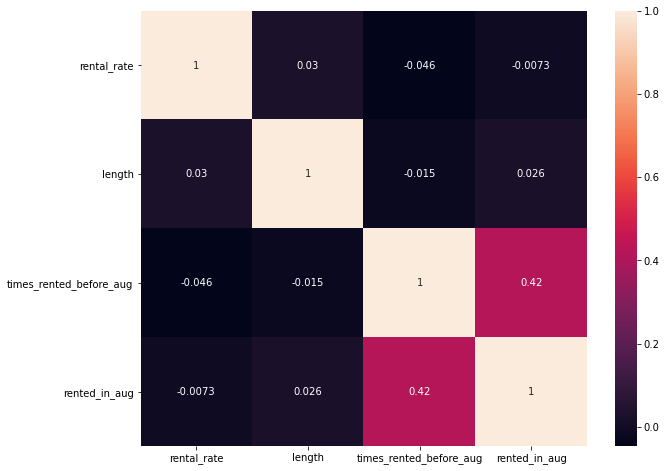

In [219]:
corr_matrix=data.corr()
fig, ax = plt.subplots(figsize=(10, 8))
ax = sns.heatmap(corr_matrix, annot=True)

In [230]:
# New Test/Train
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=31337)

In [237]:
# Scaling both train and test

from sklearn.preprocessing import StandardScaler

X_train_num = X_train.select_dtypes(include = np.number)
X_test_num = X_test.select_dtypes(include = np.number)

transformer = StandardScaler().fit(X_train_num)
X_train_num_scaled = pd.DataFrame(transformer.transform(X_train_num),columns=X_train_num.columns)
X_test_num_scaled = pd.DataFrame(transformer.transform(X_test_num),columns=X_test_num.columns)

In [244]:
# Encoding categoricals

X_train_categorical = X_train.select_dtypes(include = object)
X_train_cat = pd.get_dummies(X_train_categorical,
                            columns = ['rating', 'genre'],
                            drop_first = True)

X_test_categorical = X_test.select_dtypes(include = object)
X_test_cat = pd.get_dummies(X_test_categorical,
                            columns = ['rating', 'genre'],
                            drop_first = True)

# Resetting cat's indexes for concat to work
X_train_cat = X_train_cat.reset_index(drop=True) 
X_test_cat = X_test_cat.reset_index(drop=True) 


In [247]:
# Building final X_train and X_test

X_train_transformed = pd.concat((X_train_norm, X_train_cat), axis=1)
X_test_transformed = pd.concat((X_test_norm, X_test_cat), axis=1)

In [250]:
# Resetting y's indexes for concat to work
y_train = y_train.reset_index(drop=True) 
y_test = y_test.reset_index(drop=True) 

In [272]:
# Applying standard logistic regression

train = pd.concat([X_train_transformed, y_train],axis=1)

from sklearn.utils import resample

no_rent = train[train['rented_in_aug']==0]
yes_rent = train[train['rented_in_aug']==1]

yes_rent_undersampled = resample(yes_rent,
                                    replace=False, 
                                    n_samples = len(yes_rent)-int((len(yes_rent)-len(no_rent))/2),
                                    random_state=2)

no_rent_oversampled = resample(no_rent,
                                    replace=True,
                                    n_samples = len(no_rent)+int((len(yes_rent)-len(no_rent))/2),
                                    random_state=2)

train_underover = pd.concat([yes_rent_undersampled,no_rent_oversampled])

y = train_underover['rented_in_aug']
X = train_underover.drop('rented_in_aug',axis = 1)

LR = LogisticRegression(max_iter=100)
LR.fit(X, y)
pred = LR.predict(X_test_transformed)

from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix

display(LR.score(X_test_transformed, y_test))
print("precision: ",precision_score(y_test,pred))
print("recall: ",recall_score(y_test,pred))
print("f1: ",f1_score(y_test,pred))

display(confusion_matrix(y_test,pred))


0.925

precision:  1.0
recall:  0.9226804123711341
f1:  0.9597855227882037


array([[  6,   0],
       [ 15, 179]])

In [377]:
# Applying SMOTE

from imblearn.over_sampling import SMOTE

sm = SMOTE(random_state=100,k_neighbors=6)
X_train_SMOTE,y_train_SMOTE = sm.fit_resample(X_train_transformed,y_train)

LR = LogisticRegression(max_iter=1000)
LR.fit(X_train_SMOTE, y_train_SMOTE)
display(LR.score(X_test_transformed, y_test))
pred = LR.predict(X_test_transformed)

print("precision: ",precision_score(y_test,pred))
print("recall: ",recall_score(y_test,pred))
print("f1: ",f1_score(y_test,pred))

confusion_matrix(y_test,pred)

# Very happy with the result, all not rented movies properly predicted

0.96

precision:  1.0
recall:  0.9587628865979382
f1:  0.9789473684210526


array([[  6,   0],
       [  8, 186]])

In [380]:
# Movies not rented (predicted) vs. movies really not rented (test set)

# Index reset
y_test = y_test.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)

real = pd.concat([X_test, y_test], axis = 1)
pred = pd.DataFrame(pred, columns=['rented_in_aug'])
test = pd.concat([X_test, pred], axis = 1)


display(real[real['rented_in_aug'] == 0])
display(test[test['rented_in_aug'] == 0])

# All movies really not rented in aug (row IDs: 10, 12, 31, 42, 63, 74) were correctly predicted to not be rented in Aug by the model,
# alongside with other 8 movies that in fact were rented. Well, all models are wrong, some are useful :)

,rental_rate,length,rating,times_rented_before_aug,genre,rented_in_aug
10,4.99,50,R,0.0,Foreign,0
12,2.99,169,PG,0.0,Horror,0
31,2.99,132,PG,0.0,Action,0
42,0.99,159,NC-17,0.0,Comedy,0
63,2.99,153,PG-13,0.0,Drama,0
74,0.99,67,PG-13,0.0,New,0


,rental_rate,length,rating,times_rented_before_aug,genre,rented_in_aug
2,2.99,115,PG-13,2.0,Games,0
10,4.99,50,R,0.0,Foreign,0
12,2.99,169,PG,0.0,Horror,0
31,2.99,132,PG,0.0,Action,0
42,0.99,159,NC-17,0.0,Comedy,0
44,2.99,72,R,2.0,Documentary,0
46,2.99,180,G,2.0,Sports,0
50,0.99,112,G,3.0,Horror,0
63,2.99,153,PG-13,0.0,Drama,0
74,0.99,67,PG-13,0.0,New,0
